# 1. Identifying unique data types

The following simple script will grab all the files from your `{Firstname}{Lastname}/user-site-export` folder and print out the unique file types.

This works because the files all follow the naming format `{underscored_type}-{hyphenated-date}`. So we can split on the hyphens and take the first element of the array that returns.

In [1]:
import os

filenames = os.listdir("LoganHennessy/user-site-export")

print(f"Parsing {len(filenames)} files for unique types.")
unique_filenames = set()

for f in filenames:
    unique_filenames.add(f.split("-")[0])

print(f"Found {len(unique_filenames)} unique types.")
for name in sorted(unique_filenames):
    print(name)

Parsing 2139 files for unique types.
Found 21 unique types.
altitude
badge.json
calories
demographic_vo2_max
distance
exercise
food_logs
heart_rate
height
lightly_active_minutes
moderately_active_minutes
resting_heart_rate
run_vo2_max
sedentary_minutes
sleep
steps
swim_lengths_data
time_in_heart_rate_zones
very_active_minutes
water_logs
weight


# 2. Copy sleep files to a separate directory

There are 21 different filetypes available, but the one we're interested in is just called `sleep`. To narrow in on the data that we are going to analyze, copy these files to a separate `data` folder.

First, make a `data` directory with the `mkdir` command.

Second, copy all files beginning with `sleep` from `user-site-export`.

In [2]:
!mkdir data
!cp LoganHennessy/user-site-export/sleep* data/

mkdir: data: File exists


If that works, we should see a new `data` folder with just the sleep data.

In [3]:
!ls data

sleep-2015-07-17.json sleep-2017-08-05.json sleep-2018-10-29.json
sleep-2015-08-16.json sleep-2017-09-04.json sleep-2018-11-28.json
sleep-2015-09-15.json sleep-2017-10-04.json sleep-2018-12-28.json
sleep-2015-11-14.json sleep-2017-11-03.json sleep-2019-01-27.json
sleep-2016-04-12.json sleep-2017-12-03.json sleep-2019-02-26.json
sleep-2016-05-12.json sleep-2018-01-02.json sleep-2019-03-28.json
sleep-2016-06-11.json sleep-2018-02-01.json sleep-2019-04-27.json
sleep-2016-07-11.json sleep-2018-03-03.json sleep-2019-05-27.json
sleep-2016-08-10.json sleep-2018-04-02.json sleep-2019-06-26.json
sleep-2017-03-08.json sleep-2018-05-02.json sleep-2019-07-26.json
sleep-2017-04-07.json sleep-2018-06-01.json sleep-2019-08-25.json
sleep-2017-05-07.json sleep-2018-07-01.json sleep-2019-09-24.json
sleep-2017-06-06.json sleep-2018-07-31.json
sleep-2017-07-06.json sleep-2018-09-29.json


# 3. Read `json` files into Pandas Dataframe

In order to analyze these files, we're going to want to get them into a Pandas dataframe. Pandas provides a method for reading a single JSON file into a dataframe - `pd.read_json(file)` - but we want to read the entire folder of sleep data files into one dataframe.

To do this, just loop through all the files that are now in `data`, and create a new dataframe for each one. At the end, we'll pass a list of these dataframes to `pd.concat()` which will return a single dataframe with all the sleep data.

We'll need to import Pandas first, `os` has already been imported above.

In [4]:
import pandas as pd

dfs = []
for file in os.listdir("data"):
    dfs.append(pd.read_json(f"data/{file}"))
df = pd.concat(dfs)

In [5]:
df.head()

,dateOfSleep,duration,efficiency,endTime,infoCode,levels,logId,mainSleep,minutesAfterWakeup,minutesAsleep,minutesAwake,minutesToFallAsleep,startTime,timeInBed,type
0,2017-09-04,23700000,98,2017-09-04T08:28:30.000,0,"{'summary': {'deep': {'count': 2, 'minutes': 5...",15696252895,True,0,344,51,0,2017-09-04T01:53:00.000,395,stages
1,2017-09-03,24900000,93,2017-09-03T09:21:30.000,0,"{'summary': {'deep': {'count': 2, 'minutes': 5...",15687879032,True,9,387,28,0,2017-09-03T02:26:30.000,415,stages
2,2017-09-01,29940000,88,2017-09-01T06:01:30.000,0,"{'summary': {'deep': {'count': 5, 'minutes': 7...",15668862278,True,2,459,40,0,2017-08-31T21:42:00.000,499,stages
3,2017-08-31,27360000,86,2017-08-31T06:05:30.000,0,"{'summary': {'deep': {'count': 4, 'minutes': 6...",15659980041,True,0,414,42,0,2017-08-30T22:29:00.000,456,stages
4,2017-08-30,26220000,87,2017-08-30T07:10:30.000,0,"{'summary': {'deep': {'count': 3, 'minutes': 6...",15648457246,True,2,388,49,0,2017-08-29T23:53:30.000,437,stages


# 4. Extract the sleep phase data to the dataframe

Note how the `levels` column is still stuffed with raw `JSON` data, and isn't accessible in a useful form at the moment. We'll need to extract the useful bits of information out of the column and make them their own dataframe columns so we can analyze and plot them.

First, take a look at a single value to get a sense of how the `levels` data is structured.

In [6]:
df.iloc[0].levels['summary']

{'deep': {'count': 2, 'minutes': 50, 'thirtyDayAvgMinutes': 59},
 'wake': {'count': 6, 'minutes': 51, 'thirtyDayAvgMinutes': 57},
 'light': {'count': 11, 'minutes': 210, 'thirtyDayAvgMinutes': 213},
 'rem': {'count': 4, 'minutes': 83, 'thirtyDayAvgMinutes': 101}}

It looks like the `levels` column is simply a `dict` with a key for each of the sleep phases that FitBit tracks (deep, wake, light, and rem). Each key has another `dict` as a value with `count`, `minutes`, and `thirtyDayAvgMinutes`. We just want the `minutes` value from each phase.

Here's a simply function that can be applied to the `level` column to extract the `minutes` for a given phase.

In [7]:
def get_minutes(levels, sleep_phase):
    if not levels.get('summary'):
        return None
    if not levels.get('summary').get(sleep_phase):
        return None
    if not levels.get('summary').get(sleep_phase).get('minutes'):
        return None
    return levels['summary'][sleep_phase]['minutes']

We can run this on each of the sleep phases, generating a new column each time.

In [8]:
df['deepSleep'] = df.levels.apply(get_minutes, args=('deep',))
df['wakeMins'] = df.levels.apply(get_minutes, args=('wake',))
df['lightSleep'] = df.levels.apply(get_minutes, args=('light',))
df['remSleep'] = df.levels.apply(get_minutes, args=('rem',))

In [9]:
df.head()

,dateOfSleep,duration,efficiency,endTime,infoCode,levels,logId,mainSleep,minutesAfterWakeup,minutesAsleep,minutesAwake,minutesToFallAsleep,startTime,timeInBed,type,deepSleep,wakeMins,lightSleep,remSleep
0,2017-09-04,23700000,98,2017-09-04T08:28:30.000,0,"{'summary': {'deep': {'count': 2, 'minutes': 5...",15696252895,True,0,344,51,0,2017-09-04T01:53:00.000,395,stages,50.0,51.0,210.0,83.0
1,2017-09-03,24900000,93,2017-09-03T09:21:30.000,0,"{'summary': {'deep': {'count': 2, 'minutes': 5...",15687879032,True,9,387,28,0,2017-09-03T02:26:30.000,415,stages,58.0,28.0,216.0,112.0
2,2017-09-01,29940000,88,2017-09-01T06:01:30.000,0,"{'summary': {'deep': {'count': 5, 'minutes': 7...",15668862278,True,2,459,40,0,2017-08-31T21:42:00.000,499,stages,72.0,40.0,277.0,109.0
3,2017-08-31,27360000,86,2017-08-31T06:05:30.000,0,"{'summary': {'deep': {'count': 4, 'minutes': 6...",15659980041,True,0,414,42,0,2017-08-30T22:29:00.000,456,stages,68.0,42.0,277.0,68.0
4,2017-08-30,26220000,87,2017-08-30T07:10:30.000,0,"{'summary': {'deep': {'count': 3, 'minutes': 6...",15648457246,True,2,388,49,0,2017-08-29T23:53:30.000,437,stages,62.0,49.0,250.0,75.0


# 5. Prep dataframe for plotting

In [10]:
df.dateOfSleep = pd.to_datetime(df.dateOfSleep)
df.set_index("dateOfSleep", drop=True, inplace=True)
df.sort_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 921 entries, 2015-07-18 to 2019-09-28
Data columns (total 18 columns):
duration               921 non-null int64
efficiency             921 non-null int64
endTime                921 non-null object
infoCode               921 non-null int64
levels                 921 non-null object
logId                  921 non-null int64
mainSleep              921 non-null bool
minutesAfterWakeup     921 non-null int64
minutesAsleep          921 non-null int64
minutesAwake           921 non-null int64
minutesToFallAsleep    921 non-null int64
startTime              921 non-null object
timeInBed              921 non-null int64
type                   921 non-null object
deepSleep              766 non-null float64
wakeMins               766 non-null float64
lightSleep             766 non-null float64
remSleep               766 non-null float64
dtypes: bool(1), float64(4), int64(9), object(4)
memory usage: 130.4+ KB


In [11]:
df.drop(columns=([
    "logId", 
    "startTime", 
    "endTime", 
    "duration", 
    "minutesToFallAsleep", 
    "minutesAwake", 
    "minutesAfterWakeup", 
    "efficiency",
    "type",
    "infoCode",
    "levels",
    "mainSleep"
]), inplace=True)

In [12]:
df.dropna(inplace=True)
df.head()

,minutesAsleep,timeInBed,deepSleep,wakeMins,lightSleep,remSleep
dateOfSleep,,,,,,
2017-04-02,377,418,72.0,41.0,196.0,109.0
2017-04-03,304,330,44.0,26.0,172.0,87.0
2017-04-04,357,388,38.0,31.0,210.0,108.0
2017-04-06,254,283,32.0,29.0,155.0,66.0
2017-04-07,304,338,38.0,34.0,226.0,39.0


# 6. Plot the dataframe

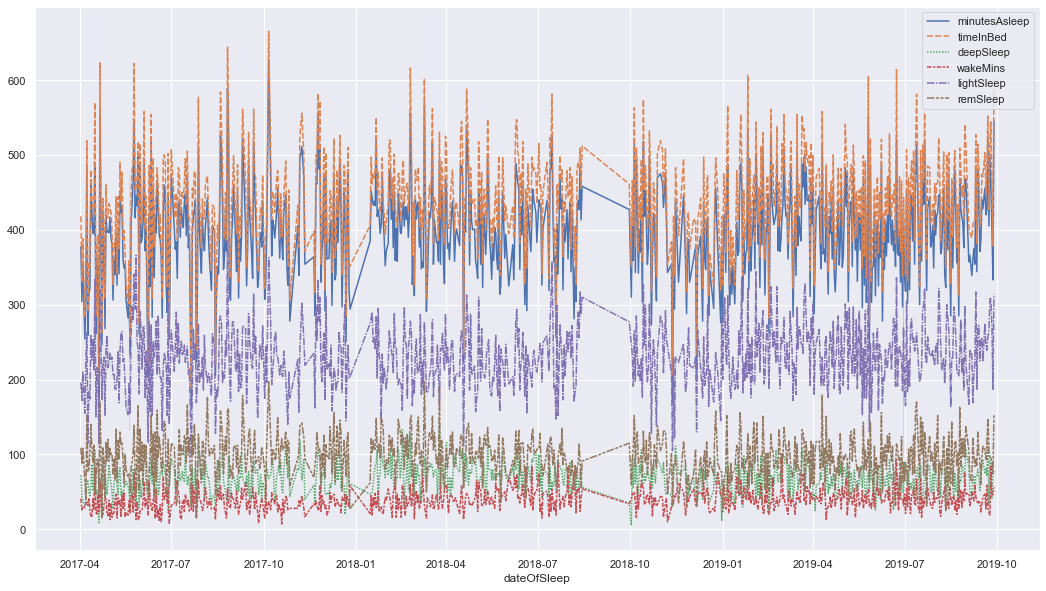

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

%matplotlib inline

register_matplotlib_converters()
sns.set()

fig, ax = plt.subplots(figsize=(18,10))
sns.lineplot(ax=ax, data=df)

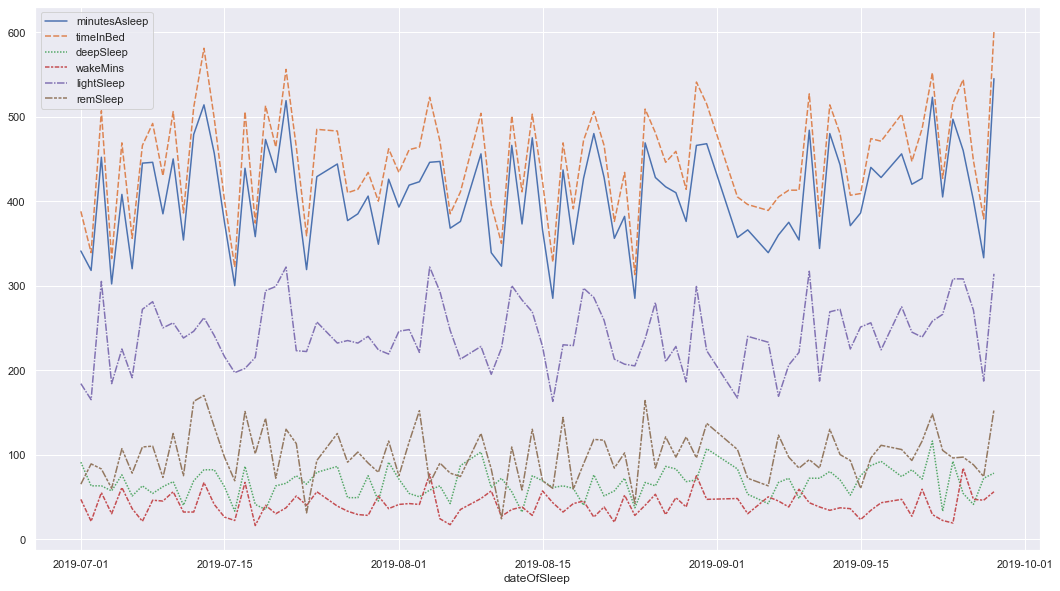

In [14]:
fig, ax = plt.subplots(figsize=(18,10))
sns.lineplot(ax=ax, data=df[df.index >= '2019-07-01'])